# <div style="color:white;display:fill;border-radius:5px;background-color:#616161;font-family:Didot;overflow:hidden"><p style="padding:18px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"><b>1 |</b>Import thư viện</p></div>

In [2]:
import pandas as pd
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
import seaborn as sns
import numpy as np
# importing required libraries for normalizing data
from sklearn.preprocessing import StandardScaler,LabelBinarizer,MinMaxScaler
from sklearn.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, MaxPool1D, Flatten, Dropout,Conv1D , BatchNormalization,Input
from keras.models import Sequential,Model # importing dense layer
# representation of model layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# <div style="color:white;display:fill;border-radius:5px;background-color:#616161;font-family:Didot;overflow:hidden"><p style="padding:18px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"><b>2 |</b>Load dữ liệu</p></div>

In [3]:
# Khởi tạo một list rỗng để lưu các DataFrame
dfs = []

# Duyệt qua các file CSV và đọc chúng vào các DataFrame
for i in range(0,2):
    filename = f"CICIoT2023/part-0000{i}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
    if i >=10 :
        filename = f"CICIoT2023/part-000{i}-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv"
    # Dữ liệu mới để test 
    df_test = pd.read_csv("CICIoT2023/part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
    df = pd.read_csv(filename)
    dfs.append(df)
#df = pd.read_csv('normal_data.csv')
#dfs.append(df)
# Ghép các DataFrame thành một DataFrame lớn
df = pd.concat(dfs)
#df = pd.read_csv("CICIoT2023/part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv")
labels_to_remove = ['DictionaryBruteForce', 'BrowserHijacking', 'XSS', 'Uploading_Attack', 'SqlInjection', 'CommandInjection', 'Backdoor_Malware']

# Filter the DataFrame to keep only rows with labels not in 'labels_to_remove'
#df = df[~df['label'].isin(labels_to_remove)]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 457492 entries, 0 to 218804
Data columns (total 47 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   flow_duration    457492 non-null  float64
 1   Header_Length    457492 non-null  float64
 2   Protocol Type    457492 non-null  float64
 3   Duration         457492 non-null  float64
 4   Rate             457492 non-null  float64
 5   Srate            457492 non-null  float64
 6   Drate            457492 non-null  float64
 7   fin_flag_number  457492 non-null  float64
 8   syn_flag_number  457492 non-null  float64
 9   rst_flag_number  457492 non-null  float64
 10  psh_flag_number  457492 non-null  float64
 11  ack_flag_number  457492 non-null  float64
 12  ece_flag_number  457492 non-null  float64
 13  cwr_flag_number  457492 non-null  float64
 14  ack_count        457492 non-null  float64
 15  syn_count        457492 non-null  float64
 16  fin_count        457492 non-null  float64
 

# <div style="color:white;display:fill;border-radius:5px;background-color:#616161;font-family:Didot;overflow:hidden"><p style="padding:18px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"> <b>3 |</b>Trực quan dữ liệu </p></div>

/tmp/ipykernel_10231/1402712567.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')


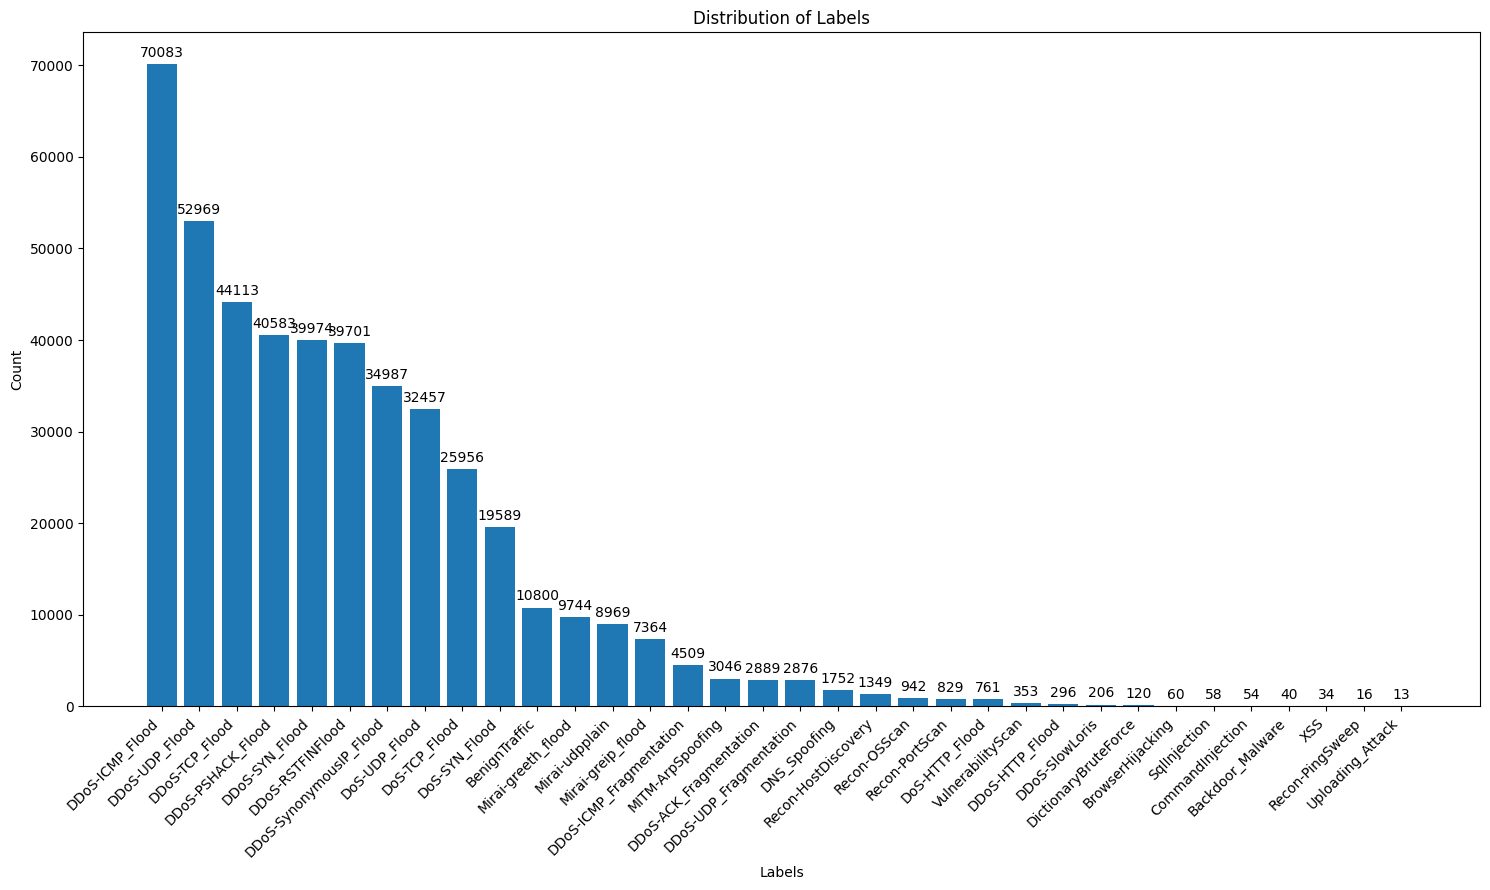

In [5]:
# Tạo biểu đồ cột
fig, ax = plt.subplots(figsize=(15, 9))
bars = ax.bar(df["label"].value_counts().index, df["label"].value_counts().values, width=0.8)

# Xoay nhãn trên trục x
ax.set_xticklabels(df["label"].value_counts().index, rotation=45, ha='right')

# Định dạng số trên trục y
ax.yaxis.set_major_formatter('{:.0f}'.format)

# Thêm nhãn và tiêu đề
ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Distribution of Labels')

# Hiển thị số liệu chính xác trên đầu mỗi cột
for bar in bars:
    height = bar.get_height()
    ax.annotate('{}'.format(height),
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

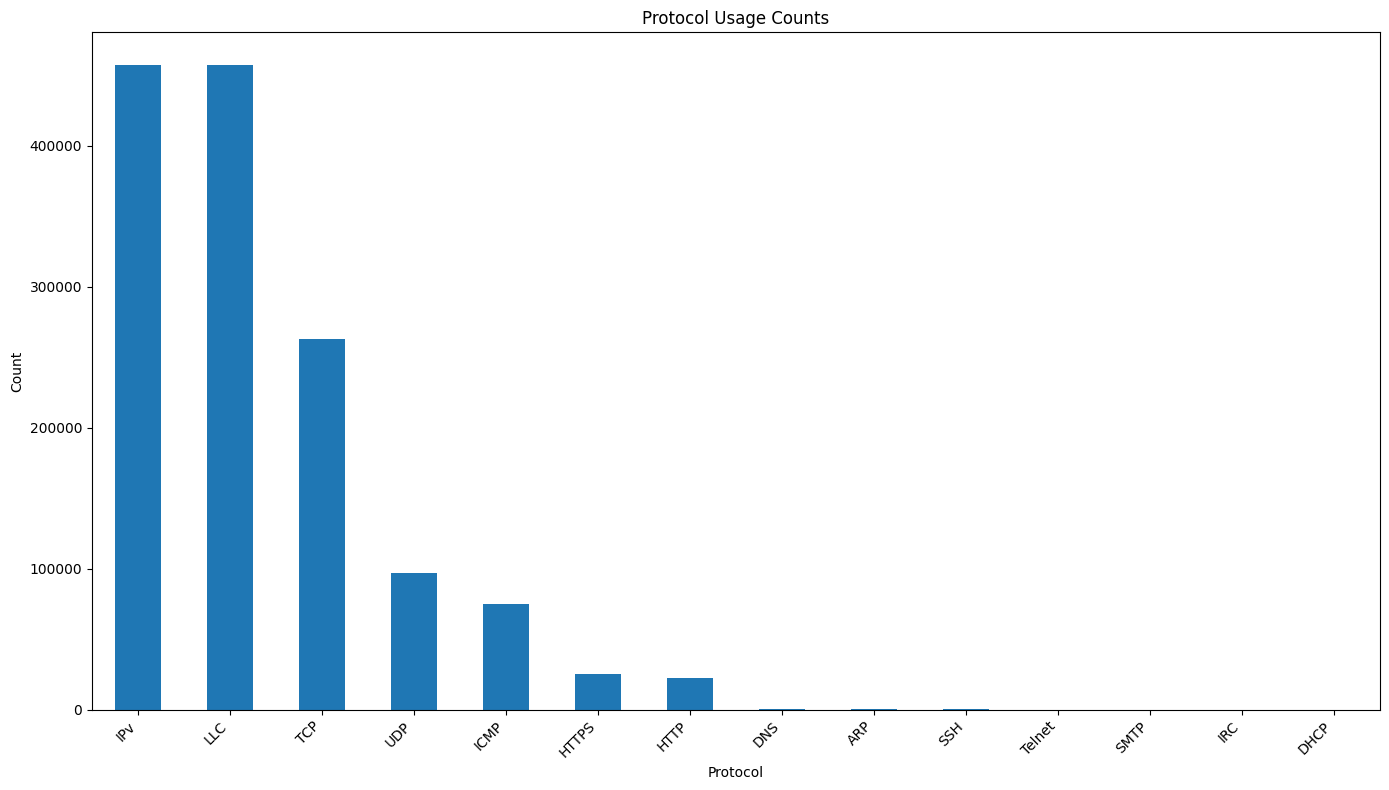

In [6]:
protocols = ['HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC']
protocol_counts = df[protocols].sum().sort_values(ascending=False)

# Now let's plot the protocol usage
plt.figure(figsize=(14, 8))
protocol_counts.plot(kind='bar')
plt.title('Protocol Usage Counts')
plt.xlabel('Protocol')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better fit
plt.tight_layout()  # Adjust layout
plt.show()

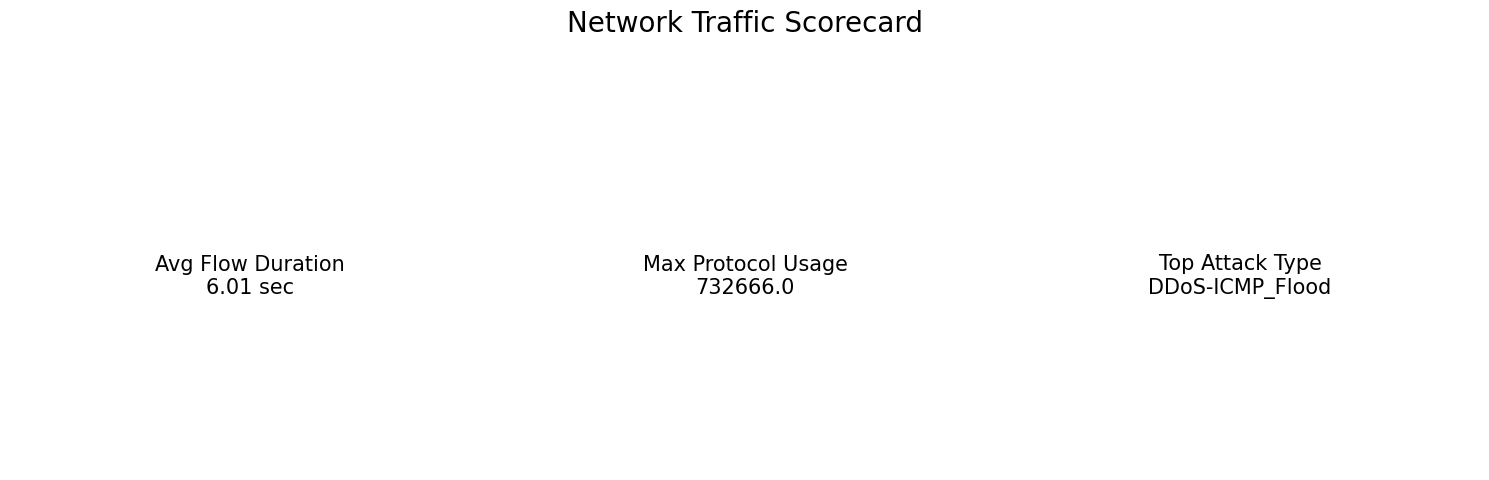

In [50]:
# Example metrics for the scorecard
average_flow_duration = df['flow_duration'].mean()
max_protocol_usage = df[protocols].sum().max()
top_attack_type = df['label'].value_counts().idxmax()

# Create the figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Network Traffic Scorecard', fontsize=20)

# Scorecard for Average Flow Duration
axs[0].text(0.5, 0.5, f'Avg Flow Duration\n{average_flow_duration:.2f} sec', fontsize=15, 
            ha='center', va='center')
axs[0].set_axis_off()

# Scorecard for Max Protocol Usage
axs[1].text(0.5, 0.5, f'Max Protocol Usage\n{max_protocol_usage}', fontsize=15, 
            ha='center', va='center')
axs[1].set_axis_off()

# Scorecard for Top Attack Type
axs[2].text(0.5, 0.5, f'Top Attack Type\n{top_attack_type}', fontsize=15, 
            ha='center', va='center')
axs[2].set_axis_off()

# Adjust the layout and display
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Gom nhãn thành 7 loại chính**

In [8]:
# phân loại lớp 
def change_label(df):
  df.label.replace(['DDoS-ICMP_Flood','DDoS-UDP_Flood','DDoS-TCP_Flood','DDoS-PSHACK_Flood','DDoS-SYN_Flood','DDoS-RSTFINFlood','DDoS-SynonymousIP_Flood','DDoS-ICMP_Fragmentation','DDoS-UDP_Fragmentation','DDoS-ACK_Fragmentation','DDoS-HTTP_Flood','DDoS-SlowLoris'],'DDos',inplace=True)
  df.label.replace(['DoS-UDP_Flood','DoS-TCP_Flood','DoS-SYN_Flood','DoS-HTTP_Flood'],'DoS',inplace=True)      
  df.label.replace(['Recon-HostDiscovery','Recon-OSScan','Recon-PortScan','Recon-PingSweep','VulnerabilityScan'],'Recon',inplace=True)
  df.label.replace(['MITM-ArpSpoofing','DNS_Spoofing'],'Spoofing',inplace=True)
  df.label.replace(['DictionaryBruteForce'],'BruteForce',inplace=True)
  df.label.replace(['BrowserHijacking','XSS','Uploading_Attack','SqlInjection','CommandInjection','Backdoor_Malware'],'Web-based',inplace=True)
  df.label.replace(['Mirai-greeth_flood','Mirai-udpplain','Mirai-greip_flood'],'Mirai',inplace=True)
  df.label.replace(['BenignTraffic'],'BENIGN',inplace=True)
change_label(df)
change_label(df_test)

# change_label(test_data)

In [9]:
df_DDOS = df[df['label'].isin(['DDos', 'BENIGN'])]
df_DDOS_test = df_test[df_test['label'].isin(['DDos', 'BENIGN'])]

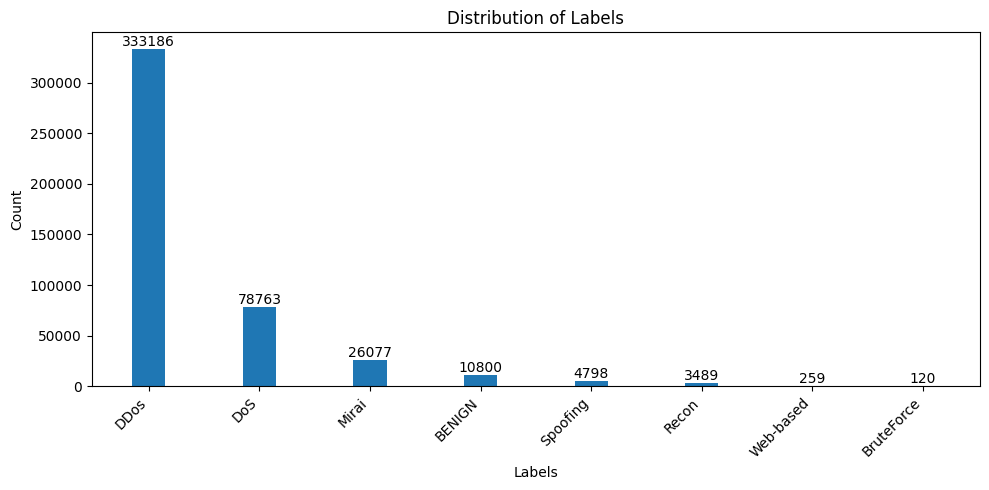

In [11]:
x_label_distribute = np.array(
   df["label"].value_counts().index.tolist())
y_label_distribute = np.array(
    df["label"].value_counts().values.tolist())
# Tạo một Figure mới với kích thước rộng 10 và cao 5
fig = plt.figure(figsize=(10, 5))
bar_width = 0.3
# Vẽ biểu đồ cột và hiển thị số liệu chính xác trên đầu mỗi cột
bars = plt.bar(x_label_distribute, y_label_distribute, width=bar_width,
               align='center')
plt.bar_label(bars, label_type='edge', fontsize=10)

# Xoay nhãn trên trục x
plt.xticks(rotation=45, ha='right')

# Định dạng số trên trục y
plt.gca().yaxis.set_major_formatter('{:.0f}'.format)

# Thêm nhãn và tiêu đề
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.tight_layout()

plt.show()


# <div style="color:white;display:fill;border-radius:5px;background-color:#616161;font-family:Didot;overflow:hidden"><p style="padding:18px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"><b>4 |</b>Biến đổi và chuẩn hóa </p></div>

In [12]:
# tạo datafreame labels (Dos,Probe,R2L,U2R,normal)
label = pd.DataFrame(df.label)

In [13]:
# Scale dữ liệu sẽ chuyển dữ liệu tỷ lệ hoặc định dạng dữ liệu về cùng một phạm vi để tránh việc các dữ liệu quá lớn ảnh hưởng tới model
# Scale dữ liệu cho từng feature numeric với train dataset
# Scale bằng MinMaxScaler để tránh giá trị âm
# Ở đây chỉ cần scale các numeric features, các thuộc tính số bởi chỉ các thuộc tính số mới có range lớn
def scaleStandardData(dataFrame, numeric_cols):
  scaler = preprocessing.StandardScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleMinMaxData(dataFrame, numeric_cols):
  scaler = preprocessing.MinMaxScaler()
  for col in numeric_cols:
    arr = dataFrame[col]
    arr = np.array(arr)
    dataFrame[col] = scaler.fit_transform(arr.reshape(len(arr),1))
  return dataFrame

def scaleData(dataFrame, numeric_cols):
  dataFrame = scaleStandardData(dataFrame, numeric_cols)
  dataFrame = scaleMinMaxData(dataFrame, numeric_cols)
  return dataFrame

In [14]:
Y_TRAIN = df_DDOS['label']
Y_TEST = df_DDOS_test['label']
X_TRAIN = df_DDOS.drop('label', axis=1).copy()
X_TEST = df_DDOS_test.drop('label', axis=1).copy()

In [15]:
import numpy as np

# Chuyển tất cả cột float64 sang float128
float_cols = X_TRAIN.select_dtypes(include=['float64']).columns
X_TRAIN[float_cols] = X_TRAIN[float_cols].astype(np.float128)
float_cols = X_TEST.select_dtypes(include=['float64']).columns
X_TEST[float_cols] = X_TEST[float_cols].astype(np.float128)

In [16]:
Y_TRAIN = Y_TRAIN.replace({'BENIGN': 0, 'DDos': 1,'DoS':2,'Mirai':3,'Spoofing':4,'Recon':5,'Web-based':6,'BruteForce':7})
Y_TEST = Y_TEST.replace({'BENIGN': 0, 'DDos': 1,'DoS':2,'Mirai':3,'Spoofing':4,'Recon':5,'Web-based':6,'BruteForce':7})

# <div style="color:white;display:fill;border-radius:5px;background-color:#616161;font-family:Didot;overflow:hidden"><p style="padding:18px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"><b>5 |</b>Feature Selection </p></div>

In [14]:
numeric_features = X_TRAIN.select_dtypes(include='number').columns
# Scale cho dữ liệu chung
X_TRAIN = scaleData(X_TRAIN, numeric_features)

In [15]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
# Áp dụng RFE để loại bỏ các feature có tác động yếu tới dữ liệu
# RFE áp dụng thuật toán cây quyết định để tìm ra các feature có tác động yếu
# Trong bài báo cáo chọn ra 30 feature có độ tác động lớn nhất
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=30, step=1)
rfe.fit(X_TRAIN, Y_TRAIN.astype(int))
X_rfeTrain=rfe.transform(X_TRAIN)
true=rfe.support_
rfecolindex_train=[i for i, x in enumerate(true) if x]
rfecolname_train=list(numeric_features[i] for i in rfecolindex_train)

In [16]:
X_TRAIN.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.000000,0.000006,0.127660,0.250980,4.493266e-08,4.493266e-08,0.0,1.0,0.0,1.0,...,0.001535,0.000000,0.000919,0.497161,0.62963,1.097532e-02,0.000000,0.000000,0.00,0.57697
1,0.000000,0.000006,0.134681,0.250980,5.845419e-07,5.845419e-07,0.0,0.0,0.0,0.0,...,0.001637,0.000257,0.001152,0.494669,0.62963,1.162250e-02,0.000258,0.000001,0.05,0.57697
2,0.000000,0.000000,0.021277,0.250980,4.549953e-06,4.549953e-06,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.495874,0.62963,2.081668e-17,0.000000,0.000000,0.00,0.57697
3,0.000005,0.007761,0.361702,0.250980,6.324404e-04,6.324404e-04,0.0,0.0,0.0,0.0,...,0.001023,0.000000,0.000613,0.495204,0.62963,7.466652e-03,0.000000,0.000000,0.00,0.57697
4,0.000002,0.000010,0.130000,0.258471,8.449842e-07,8.449842e-07,0.0,0.0,1.0,0.0,...,0.003320,0.002102,0.001216,0.494949,0.62963,1.951274e-02,0.002104,0.000022,0.19,0.57697


In [95]:
rfe.fit(X_TRAIN, Y_TRAIN.astype(int))
X_rfeTrain=rfe.transform(X_TRAIN)
true=rfe.support_
rfecolindex_train=[i for i, x in enumerate(true) if x]
rfecolname_train=list(numeric_features[i] for i in rfecolindex_train)

In [19]:
# In các đặc trưng ảnh hưởng tới lớn đến dataset
print('Features selected for Train:',rfecolname_train)

Features selected for Train: ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'syn_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'UDP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']


In [45]:
X_rfeTrain.head()

,flow_duration,Header_Length,Protocol Type,Duration,Rate,Srate,syn_flag_number,psh_flag_number,ack_flag_number,ack_count,...,AVG,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight
0,0.000000,54.00,6.00,64.00,0.329807,0.329807,0.0,0.0,0.0,1.0,...,54.000000,0.000000,54.00,8.334383e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55
1,0.000000,57.04,6.33,64.00,4.290556,4.290556,0.0,0.0,0.0,0.0,...,54.796404,2.822973,57.04,8.292607e+07,9.5,10.464666,4.010353,160.987842,0.05,141.55
2,0.000000,0.00,1.00,64.00,33.396799,33.396799,0.0,0.0,0.0,0.0,...,42.000000,0.000000,42.00,8.312799e+07,9.5,9.165151,0.000000,0.000000,0.00,141.55
3,0.328175,76175.00,17.00,64.00,4642.133010,4642.133010,0.0,0.0,0.0,0.0,...,50.000000,0.000000,50.00,8.301570e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55
4,0.117320,101.73,6.11,65.91,6.202211,6.202211,1.0,0.0,0.0,0.0,...,67.959230,23.113111,57.88,8.297300e+07,9.5,11.346876,32.716243,3016.808286,0.19,141.55


In [17]:
# Danh sách các đặc trưng quan trọng đã chọn
selected_features = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'syn_flag_number', 'psh_flag_number', 'ack_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'UDP', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']

# Chọn các đặc trưng quan trọng từ tập huấn luyện
X_rfeTrain = X_TRAIN.loc[:, selected_features]
X_TEST = X_TEST.loc[:, selected_features]

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_rfeTrain, Y_TRAIN, test_size=0.1, random_state=42)

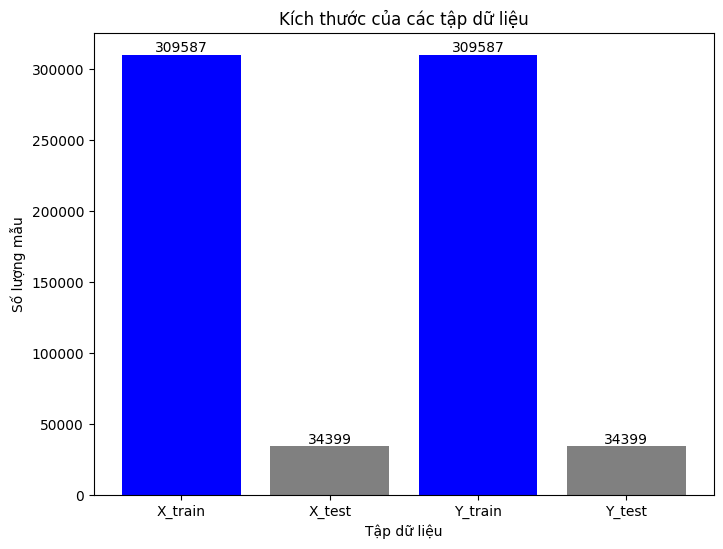

In [19]:
# Kích thước tập dữ liệu
sizes = [X_train.shape[0], X_test.shape[0], Y_train.shape[0], Y_test.shape[0]]
labels = ['X_train', 'X_test', 'Y_train', 'Y_test']

# Vẽ biểu đồ cột
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, sizes, color=['blue', 'grey', 'blue', 'grey'])
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng mẫu')
plt.title('Kích thước của các tập dữ liệu')

# Hiển thị số liệu lên đầu cột
for bar, size in zip(bars, sizes):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(size), ha='center', va='bottom', fontsize=10)

plt.show()

# <div style="color:white;display:fill;border-radius:5px;background-color:#616161;font-family:Didot;overflow:hidden"><p style="padding:18px;color:white;overflow:hidden;font-size:110%;letter-spacing:0.5px;margin:0"><b>6 |</b>CNN Model </p></div>

In [21]:
# Assuming X_train and X_test have shape (samples, time steps, features)
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)
X_TEST = np.array(X_TEST)
Y_TEST = np.array(Y_TEST)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
X_TEST = np.reshape(X_TEST, (X_TEST.shape[0], X_TEST.shape[1],1))
#y_train_encoded = to_categorical(Y_train, num_classes=8)
#y_test_encoded = to_categorical(Y_test, num_classes=8)
#Y_TEST = to_categorical(Y_TEST, num_classes=8)

In [23]:
from keras.regularizers import l2
#input_shape = (X_train.shape[1], X_train.shape[2])

model2 = Sequential()

model2.add(Conv1D(64, kernel_size=3, activation='relu', input_shape = (X_train.shape[1], 1)))
model2.add(MaxPool1D(pool_size=2))  # Adjust pool_size
model2.add(Conv1D(128, kernel_size=3, activation='relu'))
model2.add(MaxPool1D(pool_size=3))  # Adjust pool_size
model2.add(Conv1D(256, kernel_size=3, activation='relu'))
model2.add(Flatten())
model2.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model2.add(Dropout(0.2))
model2.add(Dense(1, activation='sigmoid'))  # Change the number of units to 8 for 8 classes

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 28, 64)            256       
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 14, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 12, 128)           24704     
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 4, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 2, 256)            98560     
                                                                 
 flatten (Flatten)           (None, 512)              

# **DDoS**

In [ ]:
history4 = model2.fit(X_train,Y_train, batch_size=1024, epochs=50, validation_data=(X_test,Y_test))

: 

In [27]:
model2.save('model_ddos.h5')

In [25]:
# Đánh giá trên tập huấn luyện
train_results = model2.evaluate(X_train, Y_train, verbose=1)
print(f'Train results - Loss: {train_results[0]} - Accuracy: {train_results[1]*100}%')

5432/5432 [==============================] - 96s 18ms/step - loss: 0.4510 - accuracy: 0.9695
Test results - Loss: 0.451002299785614 - Accuracy: 96.95221185684204%


In [26]:
# Đánh giá trên tập TEST mới 
test_results = model2.evaluate(X_TEST, Y_TEST, verbose=1)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {test_results[1]*100}%')

9675/9675 [==============================] - 166s 17ms/step - loss: 0.4536 - accuracy: 0.9688
Train results - Loss: 0.45361390709877014 - Accuracy: 96.87712788581848%


1075/1075 [==============================] - 28s 25ms/step
Evaluation Metrics:
╒════════════════╤══════════╕
│     Metric     │  Value   │
╞════════════════╪══════════╡
│ Accuracy (ACC) │ 0.967092 │
├────────────────┼──────────┤
│   Precision    │ 0.967092 │
├────────────────┼──────────┤
│     Recall     │    1     │
├────────────────┼──────────┤
│   F1-score:    │ 0.983271 │
╘════════════════╧══════════╛


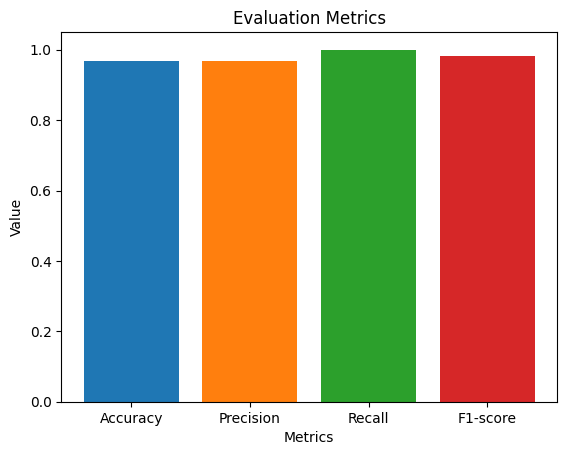

In [28]:
y_pred = model2.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
# Đánh giá hiệu quả của mô hình
accuracy = accuracy_score(Y_test, y_pred_binary)
precision = precision_score(Y_test, y_pred_binary)
recall = recall_score(Y_test, y_pred_binary)
f1 = f1_score(Y_test, y_pred_binary)
# In ra các chỉ số
print("Evaluation Metrics:")
print(tabulate([
    ["Accuracy (ACC)", accuracy],
    ["Precision", precision],
    ["Recall", recall],
    ["F1-score:", f1],
], headers=["Metric", "Value"], tablefmt="fancy_grid", numalign="center", stralign="center"))

# Vẽ biểu đồ cột với màu sắc
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
values = [accuracy, precision, recall, f1]
plt.bar(metrics, values, color=["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
plt.xlabel("Metrics")
plt.ylabel("Value")
plt.title("Evaluation Metrics")
plt.show()